
[ Mini Project 1 ]    .     .    .     .     .      .   .    .    .    .    .     .  .  .  .  . .  .         Project Code : CSDT
#Customer Satisfaction during Hotel-Stay using Decision Tree based Learning Model

Submitted by:
Group # 23

Prasanta Dutta   [20CS91F02]

Abhishek Kumar   [20CS91R02]

Deepak Mewada    [20CS91P02]


In [183]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

sns.set_style("darkgrid")


#Data Loading

In [184]:
df = pd.read_csv("/content/hoteltrain.csv")
df.head()

,wss,attenu,genre,day,meal,fqual,squal,amb,music,guests,satisfied
0,16.99,1.01,Female,Sun,Dinner,4star,2star,moderate,bollywood,2,No
1,10.34,1.66,Male,Sun,Dinner,4star,3star,high,rock,3,No
2,21.01,3.50,Male,Sun,Dinner,2star,2star,high,classical,3,Yes
3,23.68,3.31,Male,Sun,Dinner,1star,2star,high,classical,2,No
4,24.59,3.61,Female,Sun,Dinner,2star,5star,moderate,bollywood,4,yes


#Data Preprocessing

In [185]:
#This is to capitalize all lables as some label are small latter some are capital 
df["satisfied"]=df["satisfied"].str.capitalize() 
df["satisfied"].value_counts()
df1=df

In [186]:
#preprocessing the data to convert categorical data into numarical values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df.genre = le.fit_transform(df.genre)
df.day = le.fit_transform(df.day)
df.meal = le.fit_transform(df.meal)
df.fqual = le.fit_transform(df.squal)
df.squal = le.fit_transform(df.squal)
df.amb = le.fit_transform(df.amb)
df.music = le.fit_transform(df.music)
df.guests = le.fit_transform(df.guests)
df.satisfied = le.fit_transform(df.satisfied)

df

,wss,attenu,genre,day,meal,fqual,squal,amb,music,guests,satisfied
0,16.99,1.01,0,2,0,1,1,2,0,1,0
1,10.34,1.66,1,2,0,2,2,0,3,2,0
2,21.01,3.50,1,2,0,1,1,0,1,2,1
3,23.68,3.31,1,2,0,1,1,0,1,1,0
4,24.59,3.61,0,2,0,4,4,2,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...
499,17.78,3.27,1,1,0,1,1,0,1,1,0
500,24.06,3.60,1,1,0,2,2,2,0,2,0
501,16.31,2.00,1,1,0,3,3,0,1,2,1
502,32.40,6.00,1,2,0,3,3,0,1,3,1


In [187]:
df=df.rename(columns={"satisfied": "label"})

In [188]:
#defining train_test_split to split the data

def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

#Decision Tree Implementation

In [189]:
# 1. Decision Tree helper functions
# 1.1 Data pure?
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

    
# 1.2 Create Leaf
def create_leaf(data, ml_task):
    
    label_column = data[:, -1]
    if ml_task == "regression":
        leaf = np.mean(label_column)
        
    # classfication    
    else:
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        leaf = unique_classes[index]
    
    return leaf


# 1.3 Determine potential splits
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1): # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits


# 1.4 Determine Best Split
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy


def calculate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
        
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse


def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric


def determine_best_split(data, potential_splits, ml_task):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            if ml_task == "regression":
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)
            
            # classification
            else:
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_entropy)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


# 1.5 Split data
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above


# 2. Decision Tree Algorithm
# 2.1 Helper Function
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types


# 2.2 Algorithm
def decision_tree_algorithm(df, ml_task, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data, ml_task)
        return leaf

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits, ml_task)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data, ml_task)
            return leaf
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, ml_task, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, ml_task, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree


# 3. Make predictions
# 3.1 One example
def predict_example(example, tree):
    
    # tree is just a root node
    if not isinstance(tree, dict):
        return tree
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

    
# 3.2 All examples of a dataframe
def make_predictions(df, tree):
    
    if len(df) != 0:
        predictions = df.apply(predict_example, args=(tree,), axis=1)
    else:
        # "df.apply()"" with empty dataframe returns an empty dataframe,
        # but "predictions" should be a series instead
        predictions = pd.Series()
        
    return predictions


# 3.3 Accuracy
def calculate_accuracy(df, tree):
    predictions = make_predictions(df, tree)
    predictions_correct = predictions == df.label
    accuracy = predictions_correct.mean()
    
    return accuracy

#Pruning

In [190]:
def filter_df(df, question):
    feature, comparison_operator, value = question.split()
    
    # continuous feature
    if comparison_operator == "<=":
        df_yes = df[df[feature] <= float(value)]
        df_no =  df[df[feature] >  float(value)]
        
    # categorical feature
    else:
        df_yes = df[df[feature].astype(str) == value]
        df_no  = df[df[feature].astype(str) != value]
    
    return df_yes, df_no

In [191]:

def determine_leaf(df_train, ml_task):
    
    if ml_task == "regression":
        return df_train.label.mean()
    
    # classification
    else:
      dark = 0
      for value in df_train.label.value_counts():
        dark = value
        break

      return dark


In [192]:
def determine_errors(df_val, tree, ml_task):
    predictions = make_predictions(df_val, tree)
    actual_values = df_val.label
    return sum(predictions != actual_values)

In [193]:
def pruning_result(tree, df_train, df_val, ml_task):
    
    leaf = determine_leaf(df_train, ml_task)
    errors_leaf = determine_errors(df_val, leaf, ml_task)
    errors_decision_node = determine_errors(df_val, tree, ml_task)

    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree

In [194]:
def post_pruning(tree, df_train, df_val, ml_task):
    
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]

    # base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree, df_train, df_val, ml_task)
        
    # recursive part
    else:
        df_train_yes, df_train_no = filter_df(df_train, question)
        df_val_yes, df_val_no = filter_df(df_val, question)
        
        if isinstance(yes_answer, dict):
            yes_answer = post_pruning(yes_answer, df_train_yes, df_val_yes, ml_task)
            
        if isinstance(no_answer, dict):
            no_answer = post_pruning(no_answer, df_train_no, df_val_no, ml_task)
        
        tree = {question: [yes_answer, no_answer]}
    
        return pruning_result(tree, df_train, df_val, ml_task)

In [195]:
df_train, df_test= train_test_split(df, test_size=0.2)
df_train, df_val= train_test_split(df_train, test_size=0.2)
print(df_train.shape,df_test.shape,df_val.shape)

(322, 11) (101, 11) (81, 11)


In [196]:
tree_max_depth=20
model=decision_tree_algorithm(df_train, ml_task="classification", max_depth=tree_max_depth)
print(calculate_accuracy(df_test,model))

0.8811881188118812


In [197]:
model_pruned = post_pruning(model, df_train, df_val, ml_task="classification")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: Deprec

In [198]:
accuracy_tree = calculate_accuracy(df_test,model)
accuracy_tree_pruned =calculate_accuracy(df_test,model_pruned)

In [199]:
metrics = {"max_depth": [], "acc_tree": [], "acc_tree_pruned": []}
for n in range(10, 26):
    df_train, df_test = train_test_split(df, test_size=0.15)
    df_train, df_val = train_test_split(df_train, test_size=0.15)

    tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=n)
    tree_pruned = post_pruning(tree, df_train, df_val, ml_task="classification")
    
    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(df_test, tree))
    metrics["acc_tree_pruned"].append(calculate_accuracy(df_test, tree_pruned))
    
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index("max_depth")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: Deprec

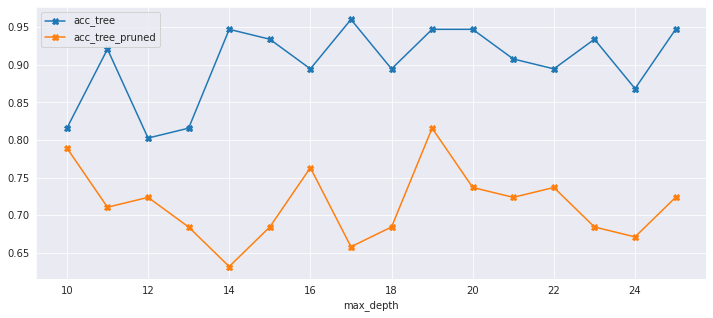

In [200]:

df_metrics.plot(figsize=(12, 5), marker="X")

##Visualisation

In [201]:
print(model)

{'amb = 2.0': [{'squal = 2.0': [0.0, {'wss <= 12.54': [{'music = 3.0': [0.0, {'day = 0.0': [{'squal = 3.0': [1.0, 0.0]}, 1.0]}]}, {'attenu <= 3.5': [{'attenu <= 3.0': [{'wss <= 14.73': [0.0, {'wss <= 16.0': [1.0, {'music = 0.0': [{'meal = 1.0': [1.0, 0.0]}, 0.0]}]}]}, 0.0]}, {'music = 0.0': [0.0, {'music = 3.0': [1.0, {'squal = 0.0': [1.0, {'meal = 1.0': [1.0, 0.0]}]}]}]}]}]}]}, {'wss <= 8.77': [0.0, {'attenu <= 1.68': [{'attenu <= 1.32': [0.0, {'amb = 1.0': [{'squal = 1.0': [1.0, 0.0]}, 1.0]}]}, {'wss <= 11.02': [0.0, {'attenu <= 3.0': [{'day = 0.0': [0.0, {'wss <= 38.01': [{'wss <= 24.55': [{'meal = 1.0': [{'squal = 1.0': [1.0, {'wss <= 15.48': [{'music = 0.0': [1.0, {'genre = 1.0': [{'attenu <= 2.0': [1.0, 0.0]}, 0.0]}]}, 0.0]}]}, {'squal = 1.0': [0.0, {'squal = 4.0': [{'genre = 1.0': [0.0, 1.0]}, {'wss <= 23.95': [{'wss <= 12.02': [0.0, {'attenu <= 2.47': [1.0, {'attenu <= 2.54': [{'amb = 1.0': [1.0, 0.0]}, 1.0]}]}]}, 0.0]}]}]}]}, 1.0]}, 0.0]}]}, {'guests = 3.0': [{'squal = 1.0': [

In [202]:
from pprint import pprint
pprint(model)

{'amb = 2.0': [{'squal = 2.0': [0.0,
                                {'wss <= 12.54': [{'music = 3.0': [0.0,
                                                                   {'day = 0.0': [{'squal = 3.0': [1.0,
                                                                                                   0.0]},
                                                                                  1.0]}]},
                                                  {'attenu <= 3.5': [{'attenu <= 3.0': [{'wss <= 14.73': [0.0,
                                                                                                          {'wss <= 16.0': [1.0,
                                                                                                                           {'music = 0.0': [{'meal = 1.0': [1.0,
                                                                                                                                                            0.0]},
                           

#Cross-validation

In [205]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
skf = StratifiedKFold(n_splits=10)
accuracy_array=[]
for train, test in skf.split(X, y):
  #print("%s %s" % (train, test))
  df1=df1.rename(columns={"satisfied": "label"})
  df_train, df_test= train_test_split(df1, test_size=0.2)
  #X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.loc[train], y.loc[test]
  
  modelCV = model=decision_tree_algorithm(df_train, ml_task="classification", max_depth=tree_max_depth)
 
  y_pred = make_predictions(df,modelCV)
  a=calculate_accuracy(df_test,model)
  accuracy_array.append(a)
print(sum(accuracy_array)/10)

0.9188118811881187


#Graph : Accuracy vs Data set % 

#Pridiction for HotelTest.csv file

In [ ]:
df = pd.read_csv("/content/hoteltest.csv")

#preprocessing the data to convert categorical data into numarical values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df.genre = le.fit_transform(df.genre)
df.day = le.fit_transform(df.day)
df.meal = le.fit_transform(df.meal)
df.fqual = le.fit_transform(df.squal)
df.squal = le.fit_transform(df.squal)
df.amb = le.fit_transform(df.amb)
df.music = le.fit_transform(df.music)
df.guests = le.fit_transform(df.guests)

df.satisfied = le.fit_transform(df.satisfied)

df=df.drop("satisfied", axis=1)
df

In [ ]:
pridiction=make_predictions(df,model)

print("This is the pridiction of customers: O means not satisfied 1 means satisfied",)
pridiction.value_counts()


#Scikit-Learn's decision tree Model

In [ ]:
# Loading data
import pandas as pd
df = pd.read_csv("/content/hoteltrain.csv")

## Converting all values of 'satisfied' column into capitalize format
df["satisfied"]=df["satisfied"].str.capitalize()
## Converting all categorical columns using LabelEncoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df.genre = le.fit_transform(df.genre)
df.day = le.fit_transform(df.day)
df.meal = le.fit_transform(df.meal)
df.fqual = le.fit_transform(df.squal)
df.squal = le.fit_transform(df.squal)
df.amb = le.fit_transform(df.amb)
df.music = le.fit_transform(df.music)
df.guests = le.fit_transform(df.guests)
df.satisfied = le.fit_transform(df.satisfied)
# Seperating feature and response variables
X = df.drop(columns="satisfied")
y = df["satisfied"]
# Doing crossvalidation on scikit-learn's data
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
# Getting the mean result
score = cross_val_score(tree, X, y, cv=10)
print("mean score after 10 fold cross validation : ",score.mean())
print("Standard deviation after 10 fold cross validation : ",score.std())

In [ ]:
clf = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=99, min_samples_leaf=5)
clf.fit(X, y)
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, filled=True)